In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import Point, Polygon
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

In [3]:
tile_root = '/work/ka1176/shared_data/2024-ufz-deeptree/Halle-DOP20-2022/'
sqlite_root = '/work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/'

In [4]:
rgbi_tiles = np.sort([tile for tile in os.listdir(tile_root) if tile.startswith('dop20rgbi') and tile.endswith('.tif')])

In [5]:
print('Total number of tiles:', len(rgbi_tiles))
print('Expected number of output sqlite databases:', len(rgbi_tiles) * 5) # 5 pretrained models
print('Total number of output sqlite databases:', len([db for db in os.listdir(sqlite_root) if db.endswith('.sqlite')]))


Total number of tiles: 76
Expected number of output sqlite databases: 380
Total number of output sqlite databases: 380


In [6]:
def geoframe_from_sqlite(dbroot, tile=None, model_id=None):
    '''
    Create a GeoDataFrame with the geometries in the SQLITE database

    Arguments:
    dbroot (str): path to SQLITE database root directory
    tile (str): TIF filename
    model_id (int): pretrained model ID
    '''

    tile = tile.replace('.tif','')
    dbfile = os.path.join(dbroot, f'{tile}_{model_id}.sqlite')
    col = f'{tile}_{model_id}'

    if not os.path.exists(dbfile):
        print('No such file', dbfile)
        return None
    
    con = sqlite3.connect(dbfile)
    cur = con.cursor()
    try:
        df = pd.read_sql_query(f"SELECT * from {col}", con)
    except:
        print('Query failed for file', dbfile)
        return None
        
    con.close()
    geo = gpd.GeoSeries.from_wkb(df['GEOMETRY']).to_frame(f'geometry')
    geo['tile'] = tile
    geo['model_id'] = model_id

    return geo

Get all polygons for all tiles and pretrained models

In [7]:
%%time
geoframes = []
for i, tile in enumerate(rgbi_tiles):
    for model_id in [0, 1, 2, 3, 4]:
        gf = geoframe_from_sqlite(sqlite_root, tile=tile, model_id=model_id)
        if gf is not None:
            geoframes.append(gf)

geoframe = pd.concat(geoframes)
geoframe.crs = 25832 # coordinate system

No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_700_5708_2_st_2022_2.sqlite
No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_704_5710_2_st_2022_rgb_0.sqlite
No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_704_5710_2_st_2022_rgb_1.sqlite
No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_704_5710_2_st_2022_rgb_2.sqlite
No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_704_5710_2_st_2022_rgb_3.sqlite
No such file /work/ka1176/shared_data/2024-ufz-deeptree/Halle-out-TCD-pretrained-rgbi/dop20rgbi_32_704_5710_2_st_2022_rgb_4.sqlite
CPU times: user 7.86 s, sys: 2.57 s, total: 10.4 s
Wall time: 11.2 s


How many trees were identified by each model

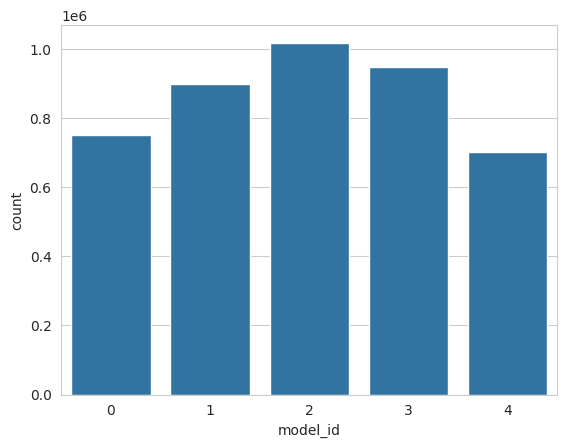

In [8]:
df = geoframe['model_id'].value_counts().to_frame().reset_index().sort_values('model_id')
sns.barplot(data=df, x='model_id', y='count')
plt.show()

Ground truth: Halle Baumkataster

In [9]:
ground_truth = gpd.read_file('/work/ka1176/shared_data/2024-ufz-deeptree/halle-baumkataster/itc005211130105323_point.shp')
ground_truth = ground_truth.to_crs(epsg=25832) # need this in the same coordinate system

Positive samples for each model

In [10]:
#intersection = geoframe.sjoin(ground_truth)
#intersection_rows = len(intersection)
#ground_truth_rows = len(ground_truth)
#print(f'All models combined: found {intersection_rows} / {ground_truth_rows} trees ({100*intersection_rows/ground_truth_rows:.2f}%)')

for model_id in list(range(5)):
    intersection = geoframe.query('model_id==@model_id').sjoin(ground_truth)
    intersection_rows = len(intersection)
    ground_truth_rows = len(ground_truth)
    print(f'Model {model_id}: found {intersection_rows} / {ground_truth_rows} trees ({100*intersection_rows/ground_truth_rows:.2f}%)')

Model 0: found 22477 / 40011 trees (56.18%)
Model 1: found 23664 / 40011 trees (59.14%)
Model 2: found 29929 / 40011 trees (74.80%)
Model 3: found 26593 / 40011 trees (66.46%)
Model 4: found 22248 / 40011 trees (55.60%)


Total tree-covered area

In [11]:
for model_id in list(range(5)):
    area = geoframe.query('model_id==@model_id').area.sum()
    print(f'Model {model_id}: Total area = {area:.2e} [a.u.]')

Model 0: Total area = 3.86e+07 [a.u.]
Model 1: Total area = 3.95e+07 [a.u.]
Model 2: Total area = 4.63e+07 [a.u.]
Model 3: Total area = 4.64e+07 [a.u.]
Model 4: Total area = 3.75e+07 [a.u.]


Union of all models
--
This is taking very long, start with a single tile

In [12]:
tile = geoframe['tile'].unique()[40]
print(tile)
tileframe = geoframe.query('tile==@tile')
zoom_box = {'left':tileframe.bounds['minx'].min(), 
            'right':tileframe.bounds['maxx'].max(), 
            'bottom':tileframe.bounds['miny'].min(), 
            'top':tileframe.bounds['maxy'].max()}
zbox = Polygon( (Point(zoom_box['left'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['bottom']), Point(zoom_box['right'], zoom_box['top']), Point(zoom_box['left'], zoom_box['top']), ) )

dop20rgbi_32_706_5702_2_st_2022


In [13]:
aggregated = tileframe.dissolve(by='model_id').reset_index()
aggregated

,model_id,geometry,tile
0,0,"MULTIPOLYGON (((706035.3 5702026.7, 706035.5 5...",dop20rgbi_32_706_5702_2_st_2022
1,1,"MULTIPOLYGON (((706017.9 5702028.7, 706019.1 5...",dop20rgbi_32_706_5702_2_st_2022
2,2,"MULTIPOLYGON (((706022.9 5702024.1, 706023.3 5...",dop20rgbi_32_706_5702_2_st_2022
3,3,"MULTIPOLYGON (((706029.9 5702026.1, 706029.7 5...",dop20rgbi_32_706_5702_2_st_2022
4,4,"MULTIPOLYGON (((706042.1 5702012.3, 706042.5 5...",dop20rgbi_32_706_5702_2_st_2022


In [14]:
n_points = 100000
sample_points = gpd.GeoDataFrame(dict(geometry=zbox), index=[0], crs=geoframe.crs).sample_points(n_points).explode(index_parts=True).to_frame('geometry').reset_index(names=['dummy', 'point_index'])

In [15]:
all_tree_points = aggregated.sjoin(sample_points, how='right').dropna()

In [16]:
all_tree_points['occurrence'] = all_tree_points.groupby('point_index')['point_index'].transform('size')
all_tree_points.head()

,index_left,model_id,tile,dummy,point_index,geometry,occurrence
10,1.0,1.0,dop20rgbi_32_706_5702_2_st_2022,0,10,POINT (706000.337 5703199.29),4
10,2.0,2.0,dop20rgbi_32_706_5702_2_st_2022,0,10,POINT (706000.337 5703199.29),4
10,3.0,3.0,dop20rgbi_32_706_5702_2_st_2022,0,10,POINT (706000.337 5703199.29),4
10,4.0,4.0,dop20rgbi_32_706_5702_2_st_2022,0,10,POINT (706000.337 5703199.29),4
11,2.0,2.0,dop20rgbi_32_706_5702_2_st_2022,0,11,POINT (706000.337 5703682.124),1


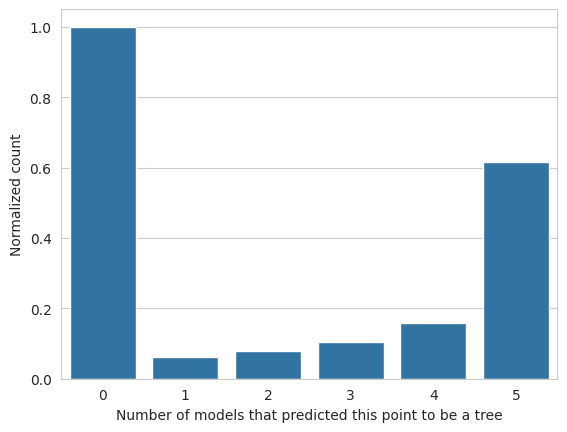

In [17]:
fig, ax = plt.subplots(1, 1)
tmp = all_tree_points['occurrence'].value_counts().to_frame().reset_index()
tmp = pd.concat([tmp, pd.DataFrame(dict(occurrence=0, count=n_points - len(all_tree_points['point_index'].unique())), index=[0])])
tmp['count'] = tmp['count'] / tmp['count'].max()
sns.barplot(data=tmp, x='occurrence', y='count')
ax.set_xlabel('Number of models that predicted this point to be a tree')
ax.set_ylabel('Normalized count')
plt.show()

Density map
- select points
- in how many polygons is this point contained?
- yields fraction

Visualize one tile